<a href="https://colab.research.google.com/github/rukmals/crowd-monitoring-system-model-development/blob/main/load_GCC_gt_as_csv_and_and_train_the_model_without_backend.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.activity.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fexperimentsandconfigs%20https%3a%2f%2fwww.googleapis.com%2fauth%2fphotos.native&response_type=code

Enter your authorization code:
4/1AX4XfWjjCvnUPDiH01QjQmWRv_tFdkdop1Vmg0dHCUSX3hiCNg2Oj3tzyyM
Mounted at /content/drive


In [ ]:
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize

  Created wheel for gputil: filename=GPUtil-1.4.0-py3-none-any.whl size=7411 sha256=7e3730a1bdcd1a3a100ccb009c84c8d3e9eaa7bc36a85ce52eac003e648a41fc
  Stored in directory: /root/.cache/pip/wheels/6e/f8/83/534c52482d6da64622ddbf72cd93c35d2ef2881b78fd08ff0c
Successfully built gputil


In [ ]:
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

Gen RAM Free: 26.3 GB  | Proc size: 118.6 MB
GPU RAM Free: 16280MB | Used: 0MB | Util   0% | Total 16280MB


In [ ]:
import random
import os
from PIL import Image,ImageFilter,ImageDraw
import numpy as np
import h5py
from PIL import ImageStat
import glob
from sklearn.model_selection import train_test_split
import json

import sys
import warnings
# import from library
import torch
import torch.nn as nn
from torch.autograd import Variable
from torchvision import datasets, transforms
import numpy as np
import argparse
import json
import cv2
import time
from torchvision import models

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

class Conv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, \
                stride=1, NL='relu', same_padding=False, bn=False, dilation=1):
        super(Conv2d, self).__init__()
        padding = int((kernel_size - 1) // 2) if same_padding else 0
        self.conv = []
        if dilation==1:
            self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding=padding, dilation=dilation)
        else:
            self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding=dilation, dilation=dilation)
        self.bn = nn.BatchNorm2d(out_channels, eps=0.001, momentum=0, affine=True) if bn else nn.Identity()
        if NL == 'relu' :
            self.relu = nn.ReLU(inplace=True)
        elif NL == 'prelu':
            self.relu = nn.PReLU()
        else:
            self.relu = None

    def forward(self, x):
      x = self.conv(x)
      if self.bn is not None:
          x = self.bn(x)
      if self.relu is not None:
          x = self.relu(x)   
      return x
  
# the module definition for the multi-branch in the density head
class MultiBranchModule(nn.Module):
    def __init__(self, in_channels, sync=False):
        super(MultiBranchModule, self).__init__()
        self.branch_column1_1 = BasicConv2d(in_channels, in_channels//2, kernel_size=1, sync=sync)
        self.branch_column1_2 = BasicConv2d(in_channels//2, in_channels, kernel_size=1, sync=sync)

        self.branch_column2_1 = BasicConv2d(in_channels, in_channels//2, kernel_size=1, sync=sync)
        self.branch_column2_2 = BasicConv2d(in_channels // 2, in_channels, kernel_size=(3, 3), padding=(1, 1), sync=sync)

        self.branch_column3_1 = BasicConv2d(in_channels, in_channels//2, kernel_size=1, sync=sync)
        self.branch_column3_2 = BasicConv2d(in_channels // 2, in_channels, kernel_size=5, padding=2, sync=sync)

    def forward(self, x):
        branch_1 = self.branch_column1_1(x)
        branch_1 = self.branch_column1_2(branch_1)

        branch_2 = self.branch_column2_1(x)
        branch_2 = self.branch_column2_2(branch_2)

        branch_3 = self.branch_column3_1(x)
        branch_3 = self.branch_column3_2(branch_3)

        outputs = [branch_1, branch_2, branch_3, x]
        return torch.cat(outputs, 1)

# the module definition for the basic conv module
class BasicConv2d(nn.Module):

    def __init__(self, in_channels, out_channels, sync=False, **kwargs):
        super(BasicConv2d, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, bias=False, **kwargs)
        if sync:
            # for sync bn
            print('use sync inception')
            self.bn = nn.SyncBatchNorm(out_channels, eps=0.001)
        else:
            self.bn = nn.BatchNorm2d(out_channels, eps=0.001)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        return F.relu(x, inplace=True)


class TestNet(nn.Module):
    def __init__(self, pretrained=True):
        super(TestNet, self).__init__()
        
        vgg = models.vgg16_bn(pretrained=pretrained)
        
        self.backend_feat  = [256,128,64]


        # Front End Development VGG - 16 
        features = list(vgg.features.children())
        # get each stage of the VGG - 16
        self.features1 = nn.Sequential(*features[0:6])
        self.features2 = nn.Sequential(*features[6:13])
        self.features3 = nn.Sequential(*features[13:23])
        self.features4 = nn.Sequential(*features[23:33])
        self.features5 = nn.Sequential(*features[33:43])

        # Front End Development P1 to P5 
        self.p5 = nn.Sequential(
            Conv2d(512, 1024, 3, same_padding=True, NL='relu'),
            Conv2d(1024, 512, 3, same_padding=True, NL='relu'),
        )

        self.p4 = nn.Sequential(
            Conv2d(1024, 512, 3, same_padding=True, NL='relu'),
            Conv2d(512, 256, 3, same_padding=True, NL='relu'),
        )

        self.p3 = nn.Sequential(
            Conv2d(512 , 256, 3, same_padding=True, NL='relu'),
            Conv2d(256, 128, 3, same_padding=True, NL='relu'),
        )

        self.p2 = nn.Sequential(
            Conv2d(256, 128, 3, same_padding=True, NL='relu'),
            Conv2d(128, 64, 3, same_padding=True, NL='relu'),
        )

        self.p1 = nn.Sequential(
            Conv2d(128, 64, 3, same_padding=True, NL='relu'),
            Conv2d(64, 64, 3, same_padding=True, NL='relu'),
        ) 

        # Multi-Branch moules
        self.multi_branch5 = nn.Sequential(
            MultiBranchModule(512),
            Conv2d(2048, 1, 1, same_padding=True)
        )

        self.multi_branch4 = nn.Sequential(
            MultiBranchModule(256),
            Conv2d(1024, 1, 1, same_padding=True)
        )

        self.multi_branch3 = nn.Sequential(
            MultiBranchModule(128),
            Conv2d(512, 1, 1, same_padding=True)
        )

        self.multi_branch2 = nn.Sequential(
            MultiBranchModule(64),
            Conv2d(256, 1, 1, same_padding=True)
        )

        self.multi_branch1 = nn.Sequential(
            MultiBranchModule(64),
            Conv2d(256, 1, 1, same_padding=True)
        )

        self.backend = make_layers(self.backend_feat,in_channels = 5,dilation = True)

        self.output_layer = nn.Conv2d(5, 1, kernel_size=1)

    
    
    def forward(self, x):
        size = x.size()
        x1 = self.features1(x)
        x2 = self.features2(x1)
        x3 = self.features3(x2)
        x4 = self.features4(x3)
        x5 = self.features5(x4)

        # Front End Development P1 to P5 
        x = self.p5(x5)
        x5_out = x
        x = F.upsample_bilinear(x, size=x4.size()[2:])

        x = torch.cat([x4, x], 1)
        x = self.p4(x)
        x4_out = x
        x = F.upsample_bilinear(x, size=x3.size()[2:])

        x = torch.cat([x3, x], 1)
        x = self.p3(x)
        x3_out = x
        x = F.upsample_bilinear(x, size=x2.size()[2:])

        x = torch.cat([x2, x], 1)
        x = self.p2(x)
        x2_out = x
        x = F.upsample_bilinear(x, size=x1.size()[2:])

        x = torch.cat([x1, x], 1)
        x = self.p1(x)
        x1_out = x


        # multi-branch predictions
        x5_density = self.multi_branch5(x5_out)
        x4_density = self.multi_branch4(x4_out)
        x3_density = self.multi_branch3(x3_out)
        x2_density = self.multi_branch2(x2_out)
        x1_density = self.multi_branch1(x1_out)

        # upsample the multi-branch predictions to be the same with the input size
        x5_density = F.upsample_nearest(x5_density, size=x1.size()[2:])
        x4_density = F.upsample_nearest(x4_density, size=x1.size()[2:])
        x3_density = F.upsample_nearest(x3_density, size=x1.size()[2:])
        x2_density = F.upsample_nearest(x2_density, size=x1.size()[2:])
        x1_density = F.upsample_nearest(x1_density, size=x1.size()[2:])


        density_map = torch.cat([x5_density, x4_density, x3_density, x2_density, x1_density], 1)


        #x_out = self.backend(density_map)
        density_map_out = self.output_layer(density_map)
        return density_map_out
        #return density_map
                
                
def make_layers(cfg, in_channels = 3,batch_norm=False,dilation = False):
    layers = []
    dilation_rates = [2,3,5]
    #for v in cfg:
    for v in range(len(cfg)):
        if cfg[v] == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            conv2d = nn.Conv2d(in_channels, cfg[v], kernel_size=3, padding=dilation_rates[v],dilation = dilation_rates[v])
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(cfg[v]), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = cfg[v]
    return nn.Sequential(*layers)

In [ ]:
import numbers
import random
import numpy as np
from PIL import Image, ImageOps, ImageFilter
import torch

class LabelNormalize(object):
    def __init__(self, para):
        self.para = para

    def __call__(self, tensor):
        # tensor = 1./(tensor+self.para).log()
        tensor = torch.from_numpy(np.array(tensor))
        tensor = tensor*self.para
        return tensor


class Compose(object):
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, img, mask, bbx=None):
        if bbx is None:
            for t in self.transforms:
                img, mask = t(img, mask)
            return img, mask
        for t in self.transforms:
            img, mask, bbx = t(img, mask, bbx)
        return img, mask, bbx

class RandomHorizontallyFlip(object):
    def __call__(self, img, mask, bbx=None):
        if random.random() < 0.5:
            if bbx is None:
                return img.transpose(Image.FLIP_LEFT_RIGHT), mask.transpose(Image.FLIP_LEFT_RIGHT)
            w, h = img.size
            xmin = w - bbx[:,3]
            xmax = w - bbx[:,1]
            bbx[:,1] = xmin
            bbx[:,3] = xmax
            return img.transpose(Image.FLIP_LEFT_RIGHT), mask.transpose(Image.FLIP_LEFT_RIGHT), bbx
        if bbx is None:
            return img, mask
        return img, mask, bbx

class RandomCrop(object):
    def __init__(self, size, padding=0):
        if isinstance(size, numbers.Number):
            self.size = (int(size), int(size))
        else:
            self.size = size
        self.padding = padding

    def __call__(self, img, mask):

        w, h = img.size
        th, tw  = self.size
        if w == tw and h == th:
            return img, mask
        if w < tw or h < th:
            return img.resize((tw, th), Image.BILINEAR), mask.resize((tw, th), Image.NEAREST)

        x1 = random.randint(0, w - tw)
        y1 = random.randint(0, h - th)
        return img.crop((x1, y1, x1 + tw, y1 + th)), mask.crop((x1, y1, x1 + tw, y1 + th))

In [ ]:
import os
import random
import pandas as pd
import torch
import numpy as np
from torch.utils.data import Dataset
from PIL import Image

def load_data(img_path,train = True):
    #path = "/content/drive/MyDrive/GCC_CSV_DataSet/Part 0/scene_00_0/csv_den_maps_k15_s4_544_960"
    gt_path = img_path.replace('.png','.csv').replace('pngs_544_960','csv_den_maps_k15_s4_544_960')
    img = Image.open(img_path)
    target = pd.read_csv(gt_path, sep=',', header=None).values
    target = target.astype(np.float32, copy=False)
    target = Image.fromarray(target)
    return img,target


class ListDataset(Dataset):
    def __init__(self, root, shape=None, shuffle=True, main_transform = None , img_transform=None, gt_transform = None, train=False, batch_size=1, num_workers=4):
        """
        if you have different image size, then batch_size must be 1
        :param root:
        :param shape:
        :param shuffle:
        :param transform:
        :param train:
        :param seen:
        :param batch_size:
        :param num_workers:
        """
        #if train:
            #root = root *4
        if shuffle:
            random.shuffle(root)
        
        self.nSamples = len(root)
        self.lines = root
        self.main_transform = main_transform
        self.img_transform = img_transform
        self.gt_transform = gt_transform
        self.train = train
        self.shape = shape
        self.batch_size = batch_size
        self.num_workers = num_workers
        
    def __len__(self):
        return self.nSamples

    def __getitem__(self, index):
        assert index <= len(self), 'index range error' 
        
        img_path = self.lines[index]
        
        img,target = load_data(img_path,self.train)

        if self.main_transform is not None:
            img, target = self.main_transform(img, target)
        if self.img_transform is not None:
            img = self.img_transform(img)
        if self.gt_transform is not None:
            target = self.gt_transform(target)   
        return img,target

In [ ]:
model = TestNet()
model = model.cuda()

Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/hub/checkpoints/vgg16_bn-6c64b313.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

In [ ]:
def get_image_path(file_path):
  file_path_list = file_path.split(" ")
  scene = file_path_list[3][4:]
  image_number = file_path_list[4]
  image_path = "/content/drive/MyDrive/GCC_CSV_DataSet/"+"Part"+"_"+scene[7]+scene+"/"+"pngs_544_960/"+image_number+".png"
  return image_path
  
def get_image_pathlist(path_list, part):
    image_path_list_part_ = []
    for line_ in path_list:
        if line_.find(part)!=-1:
            image_path_list_part_.append(line_)
    return image_path_list_part_

def extract_image_path_list(image_file, part):
  file_ = open(image_file, 'r')
  file_list = file_.readlines()
  image_path_list_train = []  
  for line in file_list:
      image_path_list_train.append(get_image_path(line))
  train_list = get_image_pathlist(image_path_list_train, part)
  print("data size: ",len(train_list))
  return train_list



In [ ]:
#img , target = load_data("/content/drive/MyDrive/GCC_CSV_DataSet/Part 0/scene_00_2/pngs_544_960/1536454705.png")
#gt_transform = transforms.Compose([LabelNormalize(100)])
#target = gt_transform(target)
#target[120]

In [ ]:
train_list = '/content/drive/MyDrive/GCC/train_list.txt'
part0_train_list = extract_image_path_list(train_list, "Part_0")
part1_train_list = extract_image_path_list(train_list, "Part_1")
part2_train_list = extract_image_path_list(train_list, "Part_2")
part3_train_list = extract_image_path_list(train_list, "Part_3")
part4_train_list = extract_image_path_list(train_list, "Part_4")
part5_train_list = extract_image_path_list(train_list, "Part_5")
part6_train_list = extract_image_path_list(train_list, "Part_6")
part7_train_list = extract_image_path_list(train_list, "Part_7")
part8_train_list = extract_image_path_list(train_list, "Part_8")
part9_train_list = extract_image_path_list(train_list, "Part_9")

data size:  1320
data size:  1160
data size:  1258
data size:  1135
data size:  1055
data size:  1037
data size:  1000
data size:  1026
data size:  992
data size:  1461


In [ ]:
test_list = '/content/drive/MyDrive/GCC/test_list.txt'
part0_test_list = extract_image_path_list(test_list, "Part_0")
part1_test_list = extract_image_path_list(test_list, "Part_1")
part2_test_list = extract_image_path_list(test_list, "Part_2")
part3_test_list = extract_image_path_list(test_list, "Part_3")
part4_test_list = extract_image_path_list(test_list, "Part_4")
part5_test_list = extract_image_path_list(test_list, "Part_5")
part6_test_list = extract_image_path_list(test_list, "Part_6")
part7_test_list = extract_image_path_list(test_list, "Part_7")
part8_test_list = extract_image_path_list(test_list, "Part_8")
part9_test_list = extract_image_path_list(test_list, "Part_9")

data size:  473
data size:  385
data size:  415
data size:  368
data size:  356
data size:  335
data size:  341
data size:  322
data size:  335
data size:  438


In [ ]:
train_data = part0_train_list + part1_train_list+part2_train_list+part3_train_list+part4_train_list+part5_train_list+part6_train_list+part7_train_list+part8_train_list+part9_train_list
test_data = part0_test_list + part1_test_list+part2_test_list+part3_test_list+part4_test_list+part5_test_list+part6_test_list+part7_test_list+part8_test_list+part9_test_list

In [ ]:
test_data[0]

'/content/drive/MyDrive/GCC_CSV_DataSet/Part_0/scene_00_0/pngs_544_960/1536387597.png'

In [ ]:
sou_main_transform = Compose([
        RandomCrop((480,480)),
        RandomHorizontallyFlip(),
        # Rand_Augment()
    ])
train_loader = torch.utils.data.DataLoader(ListDataset(train_data,shuffle=True,
                                                                main_transform = sou_main_transform,
                                                                img_transform=transforms.Compose([
                                                                transforms.ToTensor(), 
                                                                transforms.Normalize(mean=[0.302234709263, 0.291243076324, 0.269087553024],
                                                                                 std=[0.227743327618, 0.211051672697, 0.184846073389]),
                                                                ]),
                                                                gt_transform = transforms.Compose([
                                                                                LabelNormalize(100)
                                                                ]),
                                                                train=True,
                                                                batch_size=4,
                                                                num_workers=2),batch_size=4)

In [ ]:
test_loader = torch.utils.data.DataLoader(ListDataset(test_data,shuffle=False,
                                                                main_transform = None,
                                                                img_transform=transforms.Compose([
                                                                transforms.ToTensor(), 
                                                                transforms.Normalize(mean=[0.302234709263, 0.291243076324, 0.269087553024],
                                                                                 std=[0.227743327618, 0.211051672697, 0.184846073389]),
                                                                ]),
                                                                gt_transform = transforms.Compose([
                                                                                LabelNormalize(100)
                                                                ]),
                                                                train=True,
                                                                batch_size=4,
                                                                num_workers=2),batch_size=4)

In [ ]:
lr = 1e-5
criterion = nn.MSELoss(size_average=False).cuda()

#optimizer = torch.optim.SGD(model.parameters(), lr,momentum=0.95,weight_decay=5 * 1e-4)

optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.98)

/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


In [ ]:
class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.cur_val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, cur_val):
        self.cur_val = cur_val
        self.sum += cur_val
        self.count += 1
        self.avg = self.sum / self.count

In [ ]:

def mae_mse_update(pred,label,maes,mses=None,ssims=None,psnrs=None,losses=None,cls_id=None):
        for num in range(pred.size()[0]):
            sub_pred = pred[num].data.cpu().squeeze().numpy()/ 100
            sub_label = label[num].data.cpu().squeeze().numpy() / 100
            pred_cnt = np.sum(sub_pred)
            gt_cnt =   np.sum(sub_label)
            mae = abs(pred_cnt - gt_cnt)
            mse = (pred_cnt - gt_cnt)*(pred_cnt - gt_cnt)

            if ssims and psnrs is not None:
                ssims.update(get_ssim(sub_label,sub_pred))
                psnrs.update(get_psnr(sub_label,sub_pred))

            if cls_id is not None:
                maes.update(mae,cls_id)
                if losses is not None:
                    loss = F.mse_loss(pred.detach().squeeze(), label.detach().squeeze())
                    losses.update(loss.item(),cls_id)
                if mses is not None:
                    mses.update(mse,cls_id)
            else:
                maes.update(mae)
                if losses is not None:
                    loss = F.mse_loss(pred.detach().squeeze(), label.detach().squeeze())
                    losses.update(loss.item())
                if mses is not None:
                    mses.update(mse)

        return pred_cnt,gt_cnt

In [ ]:
PATH = '/content/drive/MyDrive/GCC_CSV_DataSet/model/TestNet_checkpoint_gcc_data_Whole_aug_withoutBackend.pth'
end_epoch = 13
start_epoch = 0
if (os.path.isfile(PATH))==True:
  checkpoint = torch.load(PATH)
  model.load_state_dict(checkpoint['model_state_dict'])
  optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
  start_epoch = checkpoint['epoch']
  loss = checkpoint['loss']
  print("Successfully load the check point")
else:
  print("No check point Available!!!")
print(end_epoch , start_epoch)

Successfully load the check point
13 13


In [ ]:
train_mae_file = open("/content/drive/MyDrive/GCC_CSV_DataSet/train_mae_part1and0.txt","a")
test_mae_file = open("/content/drive/MyDrive/GCC_CSV_DataSet/test_mae_part1and0.txt","a")
train_mae_file.truncate(0)
test_mae_file.truncate(0)

0

In [ ]:
for epoch in range(start_epoch,end_epoch):
    losses = AverageMeter()
    model.train()
    train_mae = AverageMeter()
    train_mse = AverageMeter()
    for i, (img, target) in enumerate(train_loader):

        img = img.cuda()
        img = Variable(img) 
        output = model(img)

        loss = criterion(output.squeeze(), target.squeeze().cuda())
        losses.update(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        sou_pred_cnt, sou_label_cnt = mae_mse_update(output, target, train_mae, train_mse)
        if i % 1000 == 0:
            print('Epoch {}, Loss={:.4f} s_gt={:.1f} s_pre={:.1f}, lr={:.4f}'.format(
                    epoch, loss.item(), sou_label_cnt,sou_pred_cnt, optimizer.param_groups[0]['lr']*10000))
    
    #scheduler.step()  
    print('train_mae_sou', float(train_mae.avg), epoch)
    print('train_mse_sou', float(np.sqrt(train_mse.avg)), epoch)
    train_mae_file.write(str(train_mae.avg))
    train_mae_file.write("\n")
    torch.save({
            'epoch': epoch+1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            }, PATH) 
    print("testing...................")  
    with torch.no_grad():
      model.eval()
      test_mae = AverageMeter()
      test_mse = AverageMeter()
      for j, (img_test, target_test) in enumerate(test_loader):
          img_test = img_test.cuda()
          img_test = Variable(img_test)   
          output_test = model(img_test)

          sou_pred_cnt_test, sou_label_cnt_test = mae_mse_update(output_test, target_test, test_mae, test_mse)
          if j % 100 == 0:
            print('Epoch {}, s_gt={:.1f} s_pre={:.1f} '.format(epoch, sou_label_cnt_test,sou_pred_cnt_test))
      print('test_mae_sou', float(test_mae.avg), epoch)
      print('test_mse_sou', float(np.sqrt(test_mse.avg)), epoch)
      test_mae_file.write(str(test_mae.avg))
      test_mae_file.write("\n")

train_mae_file.close()
test_mae_file.close()
MODEL_SAVE_PATH = '/content/drive/MyDrive/GCC_CSV_DataSet/model/TestNetGCC_whole_data_withoutbackend.pth'
torch.save(model.state_dict(), MODEL_SAVE_PATH)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3825: UserWarning: nn.functional.upsample_bilinear is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample_bilinear is deprecated. Use nn.functional.interpolate instead.")
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3770: UserWarning: nn.functional.upsample_nearest is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample_nearest is deprecated. Use nn.functional.interpolate instead.")


Epoch 11, Loss=10032.2969 s_gt=45.0 s_pre=52.5, lr=0.1000
Epoch 11, Loss=43291.6250 s_gt=11.0 s_pre=2.7, lr=0.1000
Epoch 11, Loss=11609.5479 s_gt=144.0 s_pre=143.3, lr=0.1000
train_mae_sou 34.526746422377904 11
train_mse_sou 66.89771945587708 11
testing...................
Epoch 11, s_gt=1110.9 s_pre=1169.3 
test_mae_sou 87.18532108115289 11
test_mse_sou 235.70557081647013 11
Epoch 12, Loss=12443.0879 s_gt=65.1 s_pre=69.4, lr=0.1000
Epoch 12, Loss=53624.8945 s_gt=7.0 s_pre=-10.2, lr=0.1000
Epoch 12, Loss=8482.1562 s_gt=121.0 s_pre=145.8, lr=0.1000
train_mae_sou 33.75137591089081 12
train_mse_sou 66.76562184699041 12
testing...................
Epoch 12, s_gt=1110.9 s_pre=1168.7 
test_mae_sou 55.67941544728547 12
test_mse_sou 105.05568045976558 12


In [ ]:
        """count = count + 1
        gt = np.sum(target_test.data.cpu().numpy())
        img = img_test.cuda()

        pred_map = model(img)

        pred_map = pred_map.cpu().data.numpy()[0,0,:,:]
        pred = np.sum(pred_map)/100

        score['MAE'] += np.abs(gt - pred)
        score['MSE'] += (gt - pred)*(gt - pred)
      score['MAE'], score['MSE'] = score['MAE'] / count, np.sqrt(score['MSE'] / count)  
      print("processed   MAE_in: %.2f  MSE_in: %.2f"  % ( score['MAE'], score['MSE']))
      test_mae_file.write(str(score['MAE']))
      test_mae_file.write("\n")"""

In [ ]:
file2 = open("/content/drive/MyDrive/GCC_CSV_DataSet/train_mae_part1and0.txt","r")
file3 = open("/content/drive/MyDrive/GCC_CSV_DataSet/test_mae_part1and0.txt","r")
List = file2.readlines()
List2 = file3.readlines()
epochs=[]
y_train = []
y_test = []
for i_ in range(len(List)):
  y_train.append(round(float(List[i_])))
  epochs.append(i_)
for j_ in range(len(List2)):
  y_test.append(round(float(List2[j_])))
print(y_train)
print(y_test)

[35, 34]
[87, 56]


In [ ]:
train_mae_sou 129.29131359367918 0
train_mse_sou 215.00024041455643 0
testing...................
Epoch 0, s_gt=1110.9 s_pre=1068.0 
test_mae_sou 84.33116771445279 0
test_mse_sou 202.37494896258247 0
Epoch 1, Loss=267616.1875 s_gt=1304.1 s_pre=927.8, lr=0.1000
Epoch 1, Loss=47186.9766 s_gt=52.6 s_pre=66.5, lr=0.1000
Epoch 1, Loss=4232.2002 s_gt=4.0 s_pre=3.7, lr=0.1000
train_mae_sou 70.04495716756173 1
train_mse_sou 126.46620986890042 1
testing...................
Epoch 1, s_gt=1110.9 s_pre=784.3 
test_mae_sou 85.11902582227805 1
test_mse_sou 196.43098048517604 1
Epoch 2, Loss=302057.1875 s_gt=1669.0 s_pre=1030.6, lr=0.1000
Epoch 2, Loss=59486.0234 s_gt=224.7 s_pre=242.9, lr=0.1000
Epoch 2, Loss=3772.8125 s_gt=3.0 s_pre=8.9, lr=0.1000
train_mae_sou 54.89369119181695 2
train_mse_sou 104.64495444915656 2
testing...................
Epoch 2, s_gt=1110.9 s_pre=1024.0 
test_mae_sou 107.8544876520342 2
test_mse_sou 364.2443759097911 2
Epoch 3, Loss=63830.1055 s_gt=16.0 s_pre=21.3, lr=0.1000
Epoch 3, Loss=8777.9980 s_gt=128.0 s_pre=126.6, lr=0.1000
Epoch 3, Loss=7835.1636 s_gt=33.2 s_pre=54.3, lr=0.1000
train_mae_sou 50.172166628879616 3
train_mse_sou 101.48990666700881 3
testing...................
Epoch 3, s_gt=1110.9 s_pre=1138.2 
test_mae_sou 69.59344691449417 3
test_mse_sou 171.0789664363613 3
Epoch 4, Loss=46623.0469 s_gt=15.0 s_pre=28.3, lr=0.1000
Epoch 4, Loss=9483.0713 s_gt=123.5 s_pre=130.2, lr=0.1000
Epoch 4, Loss=10640.4590 s_gt=37.0 s_pre=56.6, lr=0.1000
train_mae_sou 44.59552937503598 4
train_mse_sou 89.39420179034686 4
testing...................
Epoch 4, s_gt=1110.9 s_pre=1201.6 
test_mae_sou 62.14019922250902 4
test_mse_sou 152.67311957994147 4
Epoch 5, Loss=67921.1250 s_gt=17.0 s_pre=34.0, lr=0.1000
Epoch 5, Loss=9114.4434 s_gt=128.0 s_pre=98.5, lr=0.1000
Epoch 5, Loss=14830.3945 s_gt=174.1 s_pre=180.3, lr=0.1000
train_mae_sou 39.90904519076328 5
train_mse_sou 78.34376473533541 5
testing...................
Epoch 5, s_gt=1110.9 s_pre=1059.8 
test_mae_sou 53.12763947770474 5
test_mse_sou 137.55126047077405 5
Epoch 6, Loss=45582.5117 s_gt=10.9 s_pre=24.3, lr=0.1000
Epoch 6, Loss=6663.6797 s_gt=107.8 s_pre=100.4, lr=0.1000
Epoch 6, Loss=9187.6064 s_gt=83.1 s_pre=64.2, lr=0.1000
train_mae_sou 38.06331330066438 6
train_mse_sou 75.5750964890217 6
testing...................
Epoch 6, s_gt=1110.9 s_pre=1015.8 
test_mae_sou 61.809994129602444 6
test_mse_sou 215.10095730498435 6
Epoch 7, Loss=37187.6367 s_gt=15.0 s_pre=24.5, lr=0.1000
Epoch 7, Loss=5911.1450 s_gt=19.3 s_pre=0.3, lr=0.1000
Epoch 7, Loss=9188.8584 s_gt=86.9 s_pre=65.6, lr=0.1000
train_mae_sou 37.425433333490496 7
train_mse_sou 73.76498015156285 7
testing...................
Epoch 7, s_gt=1110.9 s_pre=1153.4 

Epoch 8, Loss=92896.5312 s_gt=1250.1 s_pre=1218.8, lr=0.1000
Epoch 8, Loss=5151.9033 s_gt=30.9 s_pre=21.8, lr=0.1000
Epoch 8, Loss=56216.5625 s_gt=1379.6 s_pre=1397.3, lr=0.1000
train_mae_sou 39.47448069457719 8
train_mse_sou 79.76326427302446 8
testing...................
Epoch 8, s_gt=1110.9 s_pre=1116.4 
test_mae_sou 71.1580152401499 8
test_mse_sou 175.2478784916937 8
Epoch 9, Loss=104165.9375 s_gt=1170.5 s_pre=1186.8, lr=0.1000
Epoch 9, Loss=26192.1602 s_gt=31.1 s_pre=32.5, lr=0.1000
Epoch 9, Loss=60892.4688 s_gt=1145.5 s_pre=1163.5, lr=0.1000
train_mae_sou 36.00943699150194 9
train_mse_sou 70.9038936762296 9
testing...................
Epoch 9, s_gt=1110.9 s_pre=1049.4 
test_mae_sou 72.5684491889492 9
test_mse_sou 121.67140761372904 9
Epoch 10, Loss=166127.4219 s_gt=1128.5 s_pre=945.1, lr=0.1000
Epoch 10, Loss=5578.7476 s_gt=29.0 s_pre=13.8, lr=0.1000
Epoch 10, Loss=38641.4727 s_gt=1231.6 s_pre=1392.6, lr=0.1000
train_mae_sou 34.75705304747068 10
train_mse_sou 67.54856596435329 10
testing...................
Epoch 10, s_gt=1110.9 s_pre=1040.0 

Epoch 11, Loss=10032.2969 s_gt=45.0 s_pre=52.5, lr=0.1000
Epoch 11, Loss=43291.6250 s_gt=11.0 s_pre=2.7, lr=0.1000
Epoch 11, Loss=11609.5479 s_gt=144.0 s_pre=143.3, lr=0.1000
train_mae_sou 34.526746422377904 11
train_mse_sou 66.89771945587708 11
testing...................
Epoch 11, s_gt=1110.9 s_pre=1169.3 
test_mae_sou 87.18532108115289 11
test_mse_sou 235.70557081647013 11
Epoch 12, Loss=12443.0879 s_gt=65.1 s_pre=69.4, lr=0.1000
Epoch 12, Loss=53624.8945 s_gt=7.0 s_pre=-10.2, lr=0.1000
Epoch 12, Loss=8482.1562 s_gt=121.0 s_pre=145.8, lr=0.1000
train_mae_sou 33.75137591089081 12
train_mse_sou 66.76562184699041 12
testing...................
Epoch 12, s_gt=1110.9 s_pre=1168.7 
test_mae_sou 55.67941544728547 12
test_mse_sou 105.05568045976558 12


In [ ]:
[129.29131359367918,70.04495716756173,54.89369119181695, 50.17216662887961, 44.59552937503598,39.90904519076328,38.06331330066438,37.425433333490496,39.47448069457719,36.00943699150194,34.75705304747068,34.526746422377904,33.75137591089081]
[84.33116771445279,85.11902582227805,107.8544876520342,  69.59344691449417,62.14019922250902,53.12763947770474,61.80999412960244, 58.12451253415524,71.1580152401499,72.5684491889492,69.12673548901234,87.18532108115289,55.67941544728547 ]

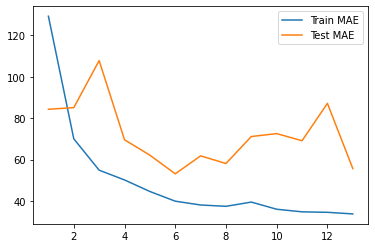

In [ ]:
import matplotlib.pyplot as plt


x1 = [1,2,3,4,5,6,7,8,9,10,11,12,13]
y1 = [129.29131359367918,70.04495716756173,54.89369119181695, 50.17216662887961, 44.59552937503598,39.90904519076328,38.06331330066438,37.425433333490496,39.47448069457719,36.00943699150194,34.75705304747068,34.526746422377904,33.75137591089081]
y2 = [84.33116771445279,85.11902582227805,107.8544876520342,  69.59344691449417,62.14019922250902,53.12763947770474,61.80999412960244, 58.12451253415524,71.1580152401499,72.5684491889492,69.12673548901234,87.18532108115289,55.67941544728547 ]
plt.plot(x1, y1)
plt.plot(x1, y2)

plt.legend(["Train MAE", "Test MAE"])

In [ ]:
train_mae_sou 108.48962813966844 0
train_mse_sou 200.11962089981992 0
test_mae_sou 128.85942962215205 0
test_mse_sou 213.14431783909887 0

train_mae_sou 67.7162981782003 1
train_mse_sou 124.8826184193291 1
test_mae_sou 89.46325803053765 1
test_mse_sou 178.06799148801042 1

train_mae_sou 58.86277042247898 2
train_mse_sou 109.64536088697174 2
test_mae_sou 108.06623770945139 2
test_mse_sou 181.19978192886322 2

train_mae_sou 51.12275562032521 3
train_mse_sou 95.08664529278737 3
test_mae_sou 102.94497794748112 3
test_mse_sou 175.28730603443034 3

train_mae_sou 46.839496924699766 4
train_mse_sou 87.5903498101021 4
test_mae_sou 115.71908665310804 4
test_mse_sou 234.65589802541544 4

train_mae_sou 44.20142215343465 5
train_mse_sou 85.34320387633312 5
test_mae_sou 68.84179198583726 5
test_mse_sou 147.57382552180368 5

train_mae_sou 39.54828710717529 6
train_mse_sou 75.4396797375224 6
test_mae_sou 83.21173518427871 6
test_mse_sou 139.84116918045666 6

train_mae_sou 39.63207350448308 7
train_mse_sou 73.24152038029344 7
test_mae_sou 54.34460122623894 7
test_mse_sou 129.33054191001648 7

train_mae_sou 41.742735190872054 8
train_mse_sou 77.91103276641365 8
test_mae_sou 66.15885164909808 8
test_mse_sou 130.90540161988332 8

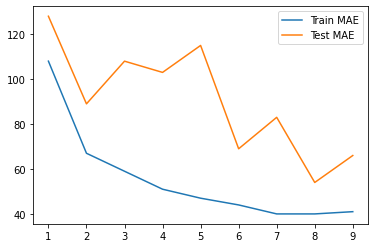

In [ ]:
import matplotlib.pyplot as plt


x1 = [1,2,3,4,5,6,7,8,9]
y1 = [108 ,67]+[59, 51, 47]+[44, 40, 40 , 41]
y2 = [128,89]+[108, 103, 115]+[69, 83, 54,66]
plt.plot(x1, y1)
plt.plot(x1, y2)

plt.legend(["Train MAE", "Test MAE"])

## Test Images


In [ ]:
model_path = '/content/drive/MyDrive/GCC_CSV_DataSet/model/TestNetGCC_whole_data_withoutbackend.pth'

model = TestNet().cuda()
# load the trained model
model.load_state_dict(torch.load(model_path))
#checkpoint = torch.load(PATH)
#model.load_state_dict(checkpoint['model_state_dict'])
print('successfully load model from', model_path)

img_transform=transforms.Compose([transforms.ToTensor(), 
                                  transforms.Normalize(mean=[0.302234709263, 0.291243076324, 0.269087553024],
                                                       std=[0.227743327618, 0.211051672697, 0.184846073389]),
                                 ])

imgname = '/content/drive/MyDrive/GCC_CSV_DataSet/Part_0/scene_02_0/pngs_544_960/1531124485.png'
denname = imgname.replace('pngs_544_960','csv_den_maps_k15_s4_544_960').replace('.png','.csv')
den = pd.read_csv(denname, sep=',',header=None).values
den = den.astype(np.float32, copy=False)
img = Image.open(imgname)
if img.mode == 'L':
  img = img.convert('RGB')
img = img_transform(img)

gt = np.sum(den)
img = img[None,:,:,:].cuda()

pred_map = model(img)

pred_map = pred_map.cpu().data.numpy()[0,0,:,:]
pred = np.sum(pred_map)/100

successfully load model from /content/drive/MyDrive/GCC_CSV_DataSet/model/TestNetGCC_whole_data_withoutbackend.pth


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3825: UserWarning: nn.functional.upsample_bilinear is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample_bilinear is deprecated. Use nn.functional.interpolate instead.")
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3770: UserWarning: nn.functional.upsample_nearest is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample_nearest is deprecated. Use nn.functional.interpolate instead.")


In [ ]:
print("Model Predicted :",int(pred))
print("Ground trueth :",int(gt))

Model Predicted : 707
Ground trueth : 574


Text(0.5, 1.0, 'Ground Trueth Count:574')

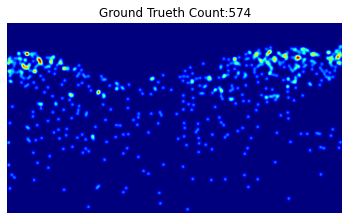

In [ ]:
from matplotlib import pyplot as plt
pred_map = pred_map/np.max(pred_map+1e-20)

den = den/np.max(den+1e-20)


den_frame = plt.gca()
plt.imshow(den,cmap='jet')
den_frame.axes.get_yaxis().set_visible(False)
den_frame.axes.get_xaxis().set_visible(False)
den_frame.spines['top'].set_visible(False)
den_frame.spines['bottom'].set_visible(False)
den_frame.spines['left'].set_visible(False)
den_frame.spines['right'].set_visible(False)
plt.title("Ground Trueth Count:"+str(int(gt)))

Text(0.5, 1.0, 'Model Predicted Count:707')

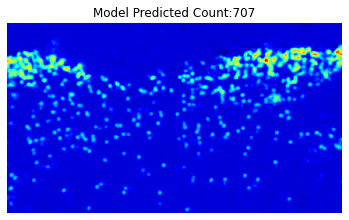

In [ ]:
pred_frame = plt.gca()
plt.imshow(pred_map,cmap='jet')
pred_frame.axes.get_yaxis().set_visible(False)
pred_frame.axes.get_xaxis().set_visible(False)
pred_frame.spines['top'].set_visible(False)
pred_frame.spines['bottom'].set_visible(False)
pred_frame.spines['left'].set_visible(False)
pred_frame.spines['right'].set_visible(False)
plt.title("Model Predicted Count:"+str(int(abs(pred))))